In [1]:
# Importing necessary libraries for data handling, analysis, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
# Selected 15 diversified S&P 500 tickers across sectors
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'JPM', 'UNH', 'XOM', 'PG', 'PFE', 'WMT', 'MCD', 'LOW', 'NFLX']

# Download historical adjusted close prices
price_data = yf.download(tickers, start='2015-01-01', end='2025-01-01', auto_adjust=True)['Close']

# Preview
price_data.head()

[*********************100%***********************]  15 of 15 completed


Ticker,AAPL,AMZN,GOOGL,JPM,LOW,MCD,META,MSFT,NFLX,NVDA,PFE,PG,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,
2015-01-02,24.320427,15.4260,26.351517,47.174263,56.062542,71.903694,78.082001,40.072117,49.848572,0.483099,19.715225,67.441566,86.192596,23.377295,59.510231
2015-01-05,23.635286,15.1095,25.849415,45.709728,54.721031,71.109550,76.827911,39.703629,47.311428,0.474939,19.608255,67.120911,84.772911,23.309259,57.881931
2015-01-06,23.637518,14.7645,25.211466,44.524529,54.845226,71.240616,75.792786,39.120899,46.501431,0.460540,19.771866,66.815186,84.601807,23.488874,57.574211
2015-01-07,23.968964,14.9210,25.137320,44.592468,56.476589,72.481949,75.792786,39.617947,46.742859,0.459340,20.042456,67.165680,85.465645,24.112089,58.157589
2015-01-08,24.889900,15.0230,25.224903,45.588943,57.669075,72.751770,77.813263,40.783417,47.779999,0.476619,20.451481,67.933739,89.545189,24.620998,59.125595


In [5]:
# Pulling latest available fundamental data using yfinance
fundamentals = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info
    fundamentals[ticker] = {
        'beta': info.get('beta', np.nan),
        'marketCap': info.get('marketCap', np.nan),
        'trailingPE': info.get('trailingPE', np.nan)
    }

# Convert to DataFrame
fundamentals_df = pd.DataFrame(fundamentals).T
fundamentals_df.head()

,beta,marketCap,trailingPE
AAPL,1.259,3.178226e+12,33.582540
MSFT,1.000,2.928096e+12,31.764517
GOOGL,1.035,1.955433e+12,17.893972
AMZN,1.393,1.993009e+12,33.898920
META,1.279,1.401601e+12,23.269503


In [6]:
# Calculating 12-month trailing returns (~252 trading days)
momentum_score = price_data.pct_change(252).iloc[-1]

# Adding momentum to the fundamentals dataframe
fundamentals_df['momentum'] = momentum_score
fundamentals_df.head()

,beta,marketCap,trailingPE,momentum
AAPL,1.259,3.178226e+12,33.582540,0.307053
MSFT,1.000,2.928096e+12,31.764517,0.129273
GOOGL,1.035,1.955433e+12,17.893972,0.360056
AMZN,1.393,1.993009e+12,33.898920,0.443925
META,1.279,1.401601e+12,23.269503,0.660489


In [7]:
# Standardizing all factor exposures (Z-scores)
factors = ['beta', 'marketCap', 'trailingPE', 'momentum']

# Negative for size and value because smaller and cheaper are preferred
fundamentals_df['Size_Score'] = -fundamentals_df['marketCap']
fundamentals_df['Value_Score'] = -fundamentals_df['trailingPE']
fundamentals_df['Momentum_Score'] = fundamentals_df['momentum']
fundamentals_df['Market_Score'] = fundamentals_df['beta']  # Higher beta = higher market exposure

# Z-score standardization
for factor in ['Market_Score', 'Size_Score', 'Value_Score', 'Momentum_Score']:
    fundamentals_df[factor] = (fundamentals_df[factor] - fundamentals_df[factor].mean()) / fundamentals_df[factor].std()

fundamentals_df.head()

,beta,marketCap,trailingPE,momentum,Size_Score,Value_Score,Momentum_Score,Market_Score
AAPL,1.259,3.178226e+12,33.582540,0.307053,-1.839258,-0.596346,-0.203690,0.593454
MSFT,1.000,2.928096e+12,31.764517,0.129273,-1.608504,-0.436921,-0.594100,-0.009467
GOOGL,1.035,1.955433e+12,17.893972,0.360056,-0.711185,0.779412,-0.087292,0.072009
AMZN,1.393,1.993009e+12,33.898920,0.443925,-0.745850,-0.624090,0.096888,0.905390
META,1.279,1.401601e+12,23.269503,0.660489,-0.200254,0.308022,0.572470,0.640012


In [8]:
# Creating a simple equal-weight composite factor score
fundamentals_df['Composite_Score'] = fundamentals_df[['Market_Score', 'Size_Score', 'Value_Score', 'Momentum_Score']].mean(axis=1)

# Ranking stocks by composite score
fundamentals_df.sort_values('Composite_Score', ascending=False).head()

,beta,marketCap,trailingPE,momentum,Size_Score,Value_Score,Momentum_Score,Market_Score,Composite_Score
NVDA,1.958,2.682948e+12,37.400307,1.712493,-1.382345,-0.931133,2.882711,2.220642,0.697469
JPM,1.005,6.804735e+11,12.014421,0.442881,0.465014,1.295001,0.094595,0.002173,0.464196
META,1.279,1.401601e+12,23.269503,0.660489,-0.200254,0.308022,0.572470,0.640012,0.330062
LOW,1.060,1.246465e+11,18.209322,0.130072,0.977785,0.751759,-0.592345,0.130206,0.316851
NFLX,1.547,4.764565e+11,52.785007,0.830677,0.653227,-2.280245,0.946209,1.263884,0.145769


In [9]:
# Selecting top 5 stocks based on Composite Score
top_stocks = fundamentals_df.sort_values('Composite_Score', ascending=False).head(5).index.tolist()

# Subsetting price data for selected stocks
portfolio_prices = price_data[top_stocks]

# Calculating daily returns
portfolio_returns = portfolio_prices.pct_change().dropna()

# Equal weighting across selected stocks
portfolio_returns = portfolio_returns.mean(axis=1)

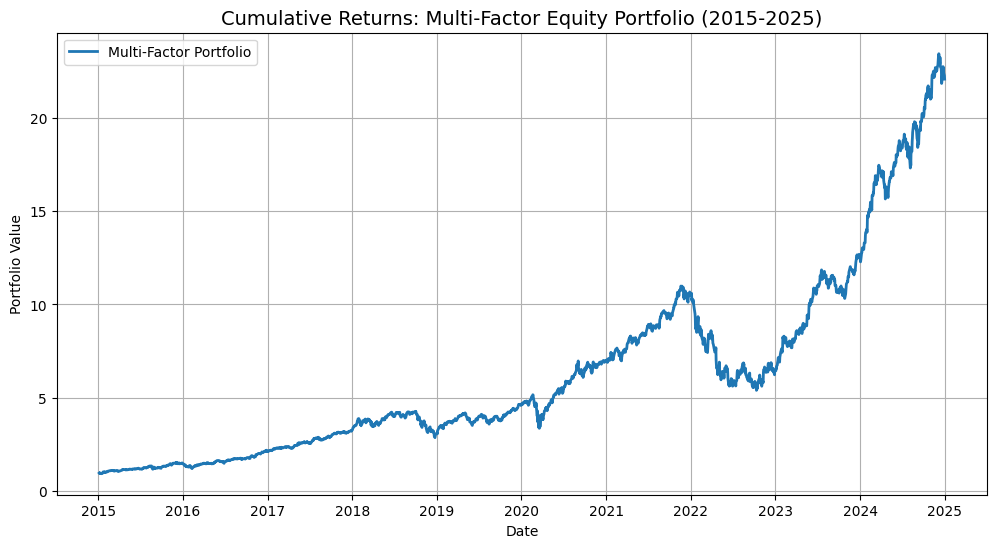

In [11]:
# Calculating cumulative portfolio returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plotting cumulative returns
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Multi-Factor Portfolio', linewidth=2)
plt.title('Cumulative Returns: Multi-Factor Equity Portfolio (2015-2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()